In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
from scipy.linalg import block_diag, solve_discrete_are
from PO.utils import make_diagonalizable_matrix, make_positive_semidefinite, plot_loss, plot_loss_sliding, compare_losses, make_diagonalizable_matrix_complex, get_hankel_new, run_multiple_runs, run_multiple_controllers,  plot_runs_with_mean, plot_multiple_controllers, plot_multiple_sliding_losses, run_multiple_models_with_params, plot_loss_comparison, plot_loss_comparison_with_ci


from PO.LQG.lqg import LQG  # new updated
from PO.GRC.grc_final import GRC # new updated
from PO.GRC.grc_stu_final import GRC_STU # new updated

from PO.DSC.dsc_final import DSC # new updated (changed after algo change)
from PO.DSC.dsc_stu_final import DSC_STU # new updated

%load_ext autoreload
%autoreload 2


In [2]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

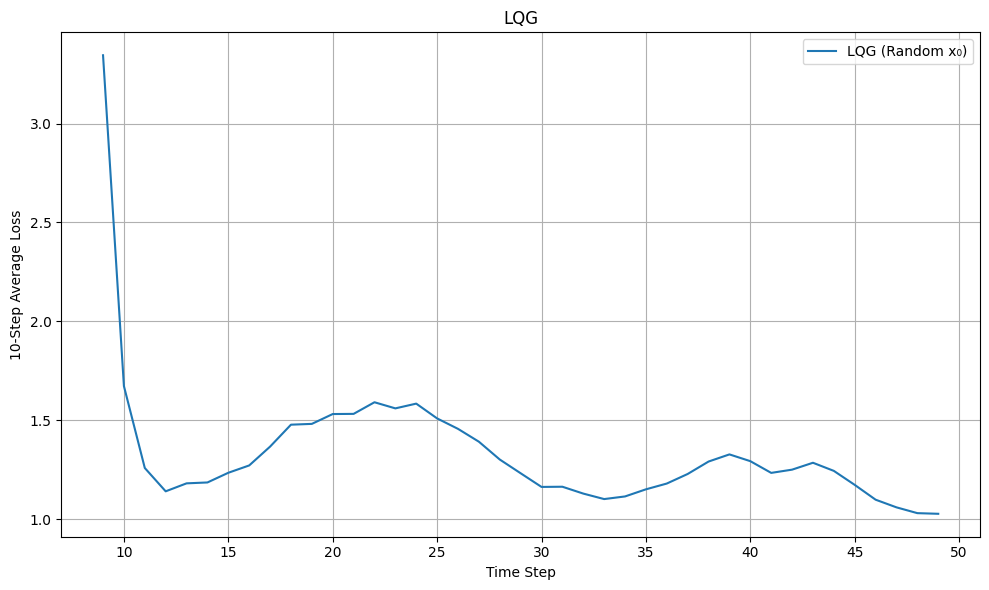

In [3]:
# LQG TESTING

if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 5  # hidden state dimension
    p = 3  # observation dimension @ 25
    n = 2   # control dimension @ 5

    T = 50  # time horizon
    window = 10  # moving average window
    num_trials = 10
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-5
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for LQG initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    controller_device = lqg_controller.device
    
    # Run simulations
    # With control
    lqg_costs = lqg_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    
    # Plot results
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'
    
    
    # Plot just LQG performance
    plot_loss_comparison(
        [lqg_controller],
        [f'LQG ({label(random_initial_state)})'],
        f"LQG",
        window_size=window
    )

In [6]:
# FOR DSC TESTING

if __name__ == "__main__":
    # # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 10  # hidden state dimension
    p = 3  # observation dimension @ 25
    n = 2  # control dimension @ 5
    T = 100  # time horizon
    window =  10  # moving average window
    num_trials = 10
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # MEMORY
    h = 3
    h_tilde = h
    m = 10
    m_tilde = m
    gamma = 0.1
    lr = 0.001  # learning rate
    
    # # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-5
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for LQG initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    #dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h, h_tilde=h_tilde, m=m, m_tilde=m_tilde, gamma=gamma, Q_noise=W_np, R_noise=V_np,T=T)
    dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h,  m=m, gamma=gamma,  Q_noise=W_np, R_noise=V_np,T=T, nl=False)
    dsc_controller_stu = DSC_STU(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h,  m=m, gamma=gamma,  Q_noise=W_np, R_noise=V_np,T=T, nl=False)
    
    controller_device = dsc_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    # Run simulations
    # With control
    dsc_costs = dsc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    dsc_controller.losses = dsc_costs

    dsc_costs_stu = dsc_controller_stu.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    dsc_controller_stu.losses = dsc_costs_stu

    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr, nl=False)
    grc_controller_stu = GRC_STU(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr, nl=False)
    # Ensure initial state is on the correct device and the same for both controllers
    #controller_device = lqg_controller.device
    
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs


    grc_costs_stu = grc_controller_stu.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller_stu.losses = grc_costs_stu


    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    controller_device = lqg_controller.device
    
    # Run simulations
    # With control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'
    
    #Plot just LQG vs GRC for clearer comparison
    # plot_loss_comparison(
    #     [dsc_controller, grc_controller],
    #     [f'DSC ({label(random_initial_state)})', 
    #         f'GRC h={h} ({label(random_initial_state)})'],
    #     f"DSC vs GRC Comparison (Linear Signal with Sinusoid Noise)",
    #     window_size=window, #save_path="PO/figures/final_results/grc_dsc_sinusoid.pdf"
    # )

    plot_loss_comparison(
        [dsc_controller_stu, grc_controller_stu],
        [f'DSC ({label(random_initial_state)})', 
            f'GRC h={h} ({label(random_initial_state)})'],
        f"DSC vs GRC Comparison (STU Signal with Gaussian Noise)",
        window_size=window, #save_path="PO/figures/final_results/grc_dsc_sinusoid.pdf"
    )

    # plot_loss_comparison(
    #     [dsc_controller, grc_controller, lqg_controller],
    #     [f'DSC ({label(random_initial_state)})', 
    #         f'GRC h={h} ({label(random_initial_state)})', f'LQG h={h} ({label(random_initial_state)})'],
    #     f"DSC vs GRC vs LQG Comparison (Noise={'On' if add_noise else 'Off'})",
    #     window_size=window #save_path="PO/figures/final_results/dsc_grc_10_3_2_wind30.png"
    # )
    
    # Option to plot both LQG and Zero Input

    # Create the labels
    # label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    # plot_loss_comparison(
    # [dsc_controller_stu],
    # [  f'DSC h={h} ({label(random_initial_state)})'],
    # f"DSC on STU (Noise={'On' if add_noise else 'Off'})",
    # window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss_30_25_5.png"
    # )

AttributeError: 'list' object has no attribute 'view'

Running LQG controller with random initial state
Process noise: On
Running GRC controller with h=3, lr=0.01


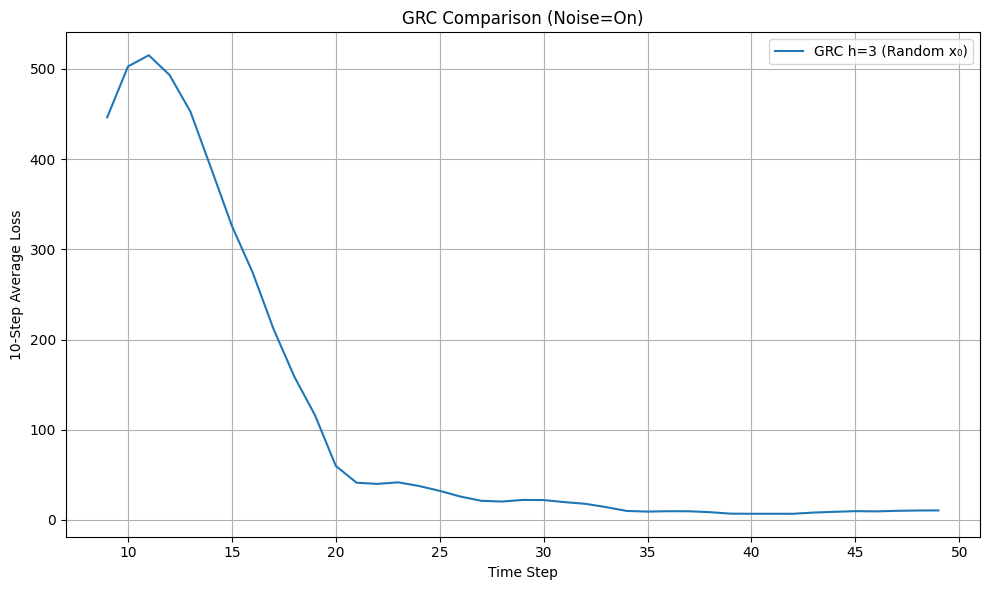

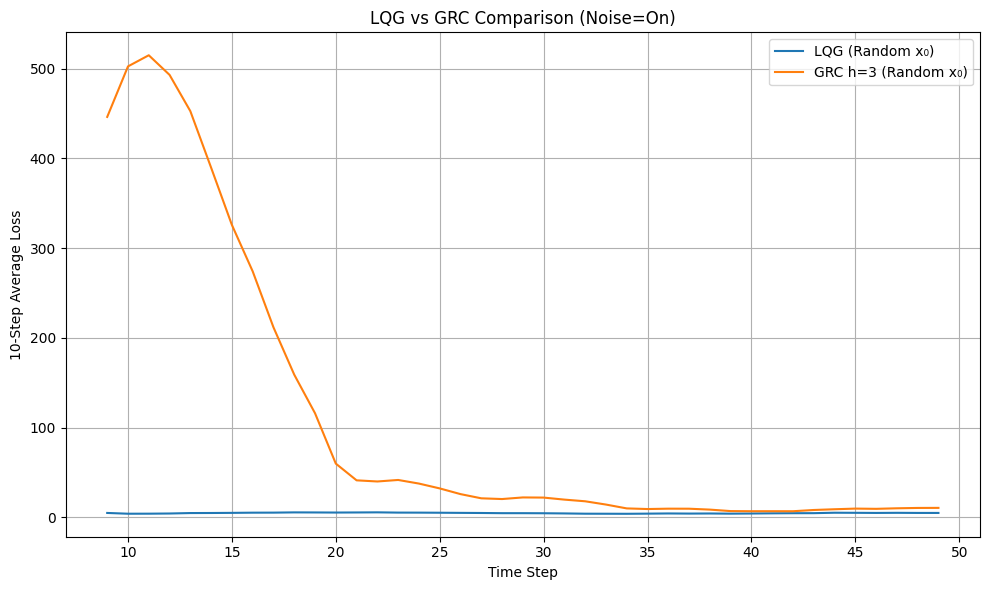

In [ ]:
# LQG vs. GRC TESTING

if __name__ == "__main__":
    #=== CONFIGURATION ===
    torch.manual_seed(42)
    d = 10  # hidden state dimension
    p = 3  # observation dimension
    n = 2   # control dimension
    T = 50  # time horizon
    window = 10  # moving average window
    num_trials = 10
    add_noise = True   # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # GRC parameters
    h = 3  # history length
    lr = 0.01  # learning rate
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-1
    
    #=== GENERATE LDS ===
    #Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    
    # Convert matrices to CPU numpy arrays for controller initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T, nl=True)
    
    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr, nl=True)
    
    # Ensure initial state is on the correct device and the same for both controllers
    controller_device = lqg_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    print(f"Running LQG controller with {'random' if random_initial_state else 'zero'} initial state")
    print(f"Process noise: {'On' if add_noise else 'Off'}")
    
    # Run LQG simulation with control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    print(f"Running GRC controller with h={h}, lr={lr}")
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    plot_loss_comparison(
        [grc_controller],
        [ 
         f'GRC h={h} ({label(random_initial_state)})'],
        f"GRC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss_30_25_5.png"
    )

    
    # Plot just LQG vs GRC for clearer comparison
    plot_loss_comparison(
        [lqg_controller, grc_controller],
        [f'LQG ({label(random_initial_state)})', 
            f'GRC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window, #save_path="PO/figures/results/grc_v_lqg_new_gauss_10_3_2_wind30_new.png"
    )

Running LQG controller with random initial state
Process noise: On
Running GRC controller with h=5, lr=0.001


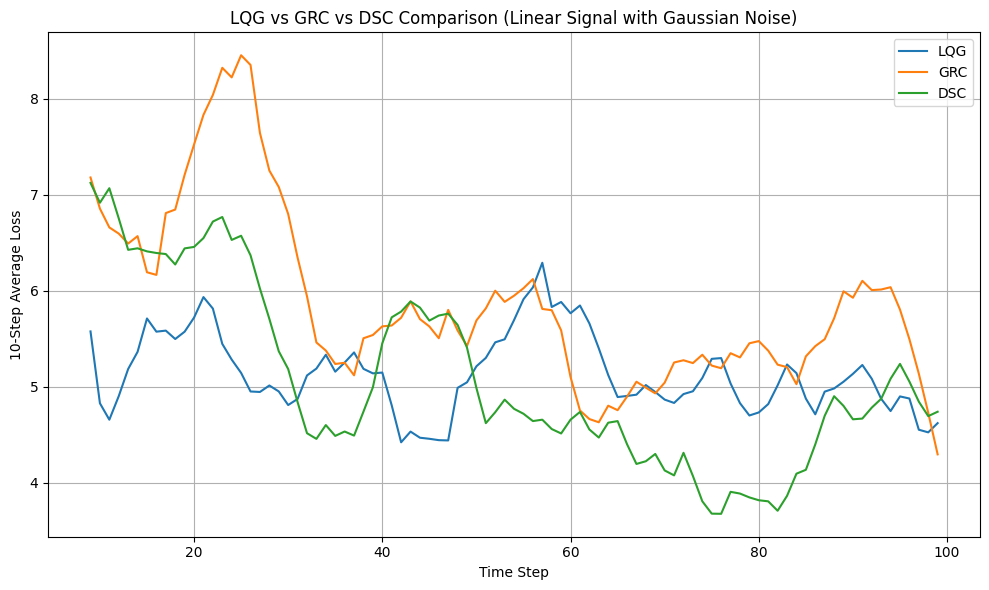

In [12]:
# TESTING ALL

if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 10 # hidden state dimension
    p = 3  # observation dimension
    n = 2   # control dimension
    T = 100  # time horizon
    window = 10  # moving average window
    num_trials = 10
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # # GRC parameters
    h = 5  # history length
    lr = 0.001  # learning rate # 0.001 for linear
    
    # === COST MATRICES ===
    Q = torch.eye(d, device=device)
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-1
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)

    
    # Convert matrices to CPU numpy arrays for controller initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_np = Q.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    #Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T, nl=False)
    
    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_np,  Q_obs=Q_obs_np, R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr, nl=False)

    # Create DSC controller with same system matrices
    #dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h, h_tilde=h_tilde, m=m, m_tilde=m_tilde, gamma=gamma, Q_noise=W_np, R_noise=V_np,T=T)
    dsc_controller = DSC(A=A_np, B=B_np, C=C_np, Q=Q_np, Q_obs=Q_obs_np, R=R_np, h=h,  m=m, gamma=gamma,  Q_noise=W_np, R_noise=V_np,T=T, nl=False)
    # Ensure initial state is on the correct device and the same for both controllers
    controller_device = lqg_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    print(f"Running LQG controller with {'random' if random_initial_state else 'zero'} initial state")
    print(f"Process noise: {'On' if add_noise else 'Off'}")
    
    # Run LQG simulation with control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    print(f"Running GRC controller with h={h}, lr={lr}")
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    # Run GRC simulation with same initial state
    dsc_costs = dsc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    dsc_controller.losses = dsc_costs
     
    #Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    
    # Plot just LQG vs GRC for clearer comparison
    plot_loss_comparison(
        [lqg_controller, grc_controller, dsc_controller],
        [f'LQG', 
         f'GRC', f'DSC'],
        f"LQG vs GRC vs DSC Comparison (Linear Signal with Gaussian Noise)",
        window_size=window, #save_path="PO/figures/FINAL_results/all_new_10_3_2_wind10_hist5_10trials_RELU.pdf"
    )
    # plot_loss_comparison(
    #     [lqg_controller, dsc_controller],
    #     [f'LQG ({label(random_initial_state)})', 
    #     f'DSC h={h} ({label(random_initial_state)})'],
    #     f"LQG vs GRC vs DSC Comparison (Noise={'Gaussian' if add_noise else 'Off'})",
    #     window_size=window, #save_path="PO/figures/results/all_new_10_4_2.png"
    # )

In [ ]:
 plot_loss_comparison(
        [lqg_controller, grc_controller],
        [f'LQG ({label(random_initial_state)})', 
         f'GRC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC  Comparison (Noise={'Gaussian' if add_noise else 'Off'})",
        window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss_30_25_5.png"
    )

In [ ]:
means, lowers, uppers = plot_loss_comparison_with_ci(
    [lqg_controller, grc_controller],
    [f'LQG ({label(random_initial_state)})', f'GRC h={h} ({label(random_initial_state)})'],
    f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
    window_size=20,
    confidence=0.95
)
mean_lqg, mean_grc = means
lower_lqg, lower_grc = lowers
upper_lqg, upper_grc = uppers

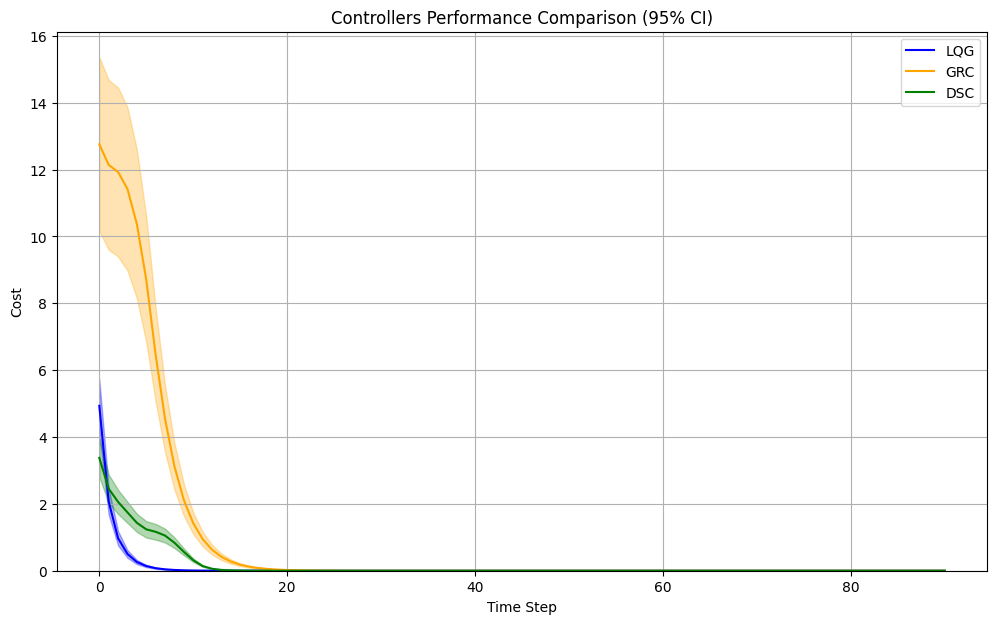

In [9]:
controller_configs = [
    ("LQG", LQG, {
        'A': A_np, 'B': B_np, 'C': C_np, 'Q': Q_np, 'Q_obs': Q_obs_np, 'R': R_np,
        'Q_noise': W_np, 'R_noise': V_np, 'T': T, 'nl': False
    }),
    ("GRC", GRC, {
        'A': A_np, 'B': B_np, 'C': C_np, 'Q': Q_np, 'Q_obs': Q_obs_np, 'R': R_np,
        'Q_noise': W_np, 'R_noise': V_np, 'h': h, 'T': T, 'lr': lr, 'nl': False
    }),
    ("DSC", DSC, {
        'A': A_np, 'B': B_np, 'C': C_np, 'Q': Q_np, 'Q_obs': Q_obs_np, 'R': R_np,
        'Q_noise': W_np, 'R_noise': V_np, 'h': h, 'm': m, 'gamma': gamma, 'T': T, 'nl': False
    })
]

# Run all controllers
all_results = run_multiple_models_with_params(controller_configs, num_runs=100)

custom_colors = {
    "LQG": "blue",
    "GRC": "orange",
    "DSC": "green"
}

plot_loss_comparison_with_ci(
    all_results,
    "Controllers Performance Comparison (95% CI)",
    window_size=10,
    confidence=0.95,
    colors=custom_colors,
    ylim=(0, None)
)
